In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import Funciones_MCF as MCF
from scipy.stats import kurtosis, skew ,norm

In [27]:
M7 = ['AAPL','MSFT','NVDA','TSLA']


df_precios = MCF.obtener_datos(M7)
df_precios

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,MSFT,NVDA,TSLA
Date,,,,
2024-03-21,170.564606,426.116760,91.404961,172.820007
2024-03-22,171.470352,425.491547,94.258026,170.830002
2024-03-25,170.047073,419.656067,94.970787,172.630005
2024-03-26,168.912430,418.455231,92.530594,177.669998
2024-03-27,172.495499,418.236908,90.220345,179.830002
...,...,...,...,...
2025-03-14,213.490005,388.559998,121.669998,249.979996
2025-03-17,214.000000,388.700012,119.529999,238.009995
2025-03-18,212.690002,383.519989,115.430000,225.309998


In [28]:
df_rendimientos = MCF.calcular_rendimientos(df_precios)
df_rendimientos

Ticker,AAPL,MSFT,NVDA,TSLA
Date,,,,
2024-03-22,0.005310,-0.001467,0.031213,-0.011515
2024-03-25,-0.008300,-0.013715,0.007562,0.010537
2024-03-26,-0.006673,-0.002861,-0.025694,0.029195
2024-03-27,0.021213,-0.000522,-0.024967,0.012157
2024-03-28,-0.010559,-0.001685,0.001175,-0.022466
...,...,...,...,...
2025-03-14,0.018171,0.025847,0.052691,0.038641
2025-03-17,0.002389,0.000360,-0.017589,-0.047884
2025-03-18,-0.006121,-0.013327,-0.034301,-0.053359


In [29]:
promedio_rendi_diario = df_rendimientos['AAPL'].mean()
promedio_rendi_diario


0.0010317944070705836

In [30]:
kurtosis = kurtosis(df_rendimientos['AAPL'])
skew = skew(df_rendimientos['AAPL'])
kurtosis

2.6676033193745576

# Cálculo de VaR y CVaR asumiendo normalidad

## VaR Paramétrico

Para este VaR asumimos que nuestra muestra tiene una distribución normal.

1. Calcular la Media y la Desviación Estándar:

    mean = np.mean(returns): Calcula el retorno diario promedio de la serie. Esto representa el retorno esperado.

    stdev = np.std(returns): Calcula la desviación estándar de los retornos, que mide la volatilidad o el riesgo de los retornos.


2. Calcular el VaR:

    VaR_95 = norm.ppf(1-0.95, mean, stdev): Esta línea calcula el VaR al 95% usando el inverso de la función de distribución acumulativa (CDF) de la distribución normal (norm.ppf). El primer argumento 1-0.95 representa el nivel de confianza (5% en este caso, que es 1 - 95%). Los segundo y tercer argumentos son la media y la desviación estándar de los retornos, respectivamente. Esta función devuelve el valor en el cual termina el extremo izquierdo de la distribución normal, representando el umbral de pérdida que no se superará con un 95% de confianza en un período especificado (en este caso, presumiblemente un día, dado los datos de retornos diarios).

In [31]:
mean = np.mean(df_rendimientos['AAPL'])
stdev = np.std(df_rendimientos['AAPL'])

VaR_95=norm.ppf(1-0.95,mean,stdev)

print("95% VaR of AAPL:", round(VaR_95*100,4))

95% VaR of AAPL: -2.4312


## VaR Histórico

Calcular el VaR Histórico:

hVaR_95 = returns.quantile(0.05): Esta línea calcula el percentil 5% (quantile 0.05) de la distribución de retornos históricos. En el contexto del VaR, esto significa que se busca el valor de retorno tal que el 5% de los retornos históricos sean iguales o menores a ese valor. Al trabajar con un nivel de confianza del 95%, se está interesado en el límite inferior del 5% de los resultados más negativos, ya que el VaR se enfoca en pérdidas potenciales.

In [32]:
# Historical VaR
hVaR_95 = df_rendimientos['AAPL'].quantile(0.05)

print("95% VaR of AAPL:", round(hVaR_95*100,4))

95% VaR of AAPL: -2.586


## VaR Monte Carlo

1. Número de Simulaciones:

    n_sims = 100000: Se define la cantidad de simulaciones a realizar. En este caso, se generarán 100,000 series de retornos simulados. Cuantas más simulaciones se realicen, más precisa será la estimación del VaR, aunque también requerirá más tiempo de cálculo.

2. Simular Retornos y Ordenar:

    sim_returns = np.random.normal(mean, stdev, n_sims): Se simulan los retornos utilizando una distribución normal, donde mean y stdev son la media y la desviación estándar de los retornos históricos, respectivamente. Esto genera una serie de retornos simulados basados en la suposición de que los retornos siguen una distribución normal.

3. Calcular el VaR de Monte Carlo:

    MCVaR_95 = np.percentile(sim_returns, 5): Se calcula el percentil 5 de los retornos simulados, lo que representa el VaR al 95%. Esto significa que se espera que el 5% de los peores retornos sean iguales o peores que este valor. Dicho de otra forma, hay un 95% de confianza de que las pérdidas no superarán este valor de VaR.

In [33]:
# Monte Carlo

# Number of simulations
n_sims = 100000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

MCVaR_95 = np.percentile(sim_returns, 5)

print("95% VaR of AAPL:", round(MCVaR_95*100,4))

95% VaR of AAPL: -2.4434


## CVaR o ES

Calcular el CVaR al 95%:

CVaR_95=returns[returns<=hVaR_95].mean(): Este código calcula el CVaR como el promedio de todos los retornos que son iguales o menores que el VaR histórico al 95% (hVaR_95). En otras palabras, primero se filtran los retornos para quedarse solo con aquellos que están en el peor 5% (los retornos que son peores que el VaR) y luego se calcula la media de estos retornos. El resultado es el CVaR al 95%, que representa el promedio de las pérdidas esperadas en el peor 5% de los escenarios.

In [34]:
# CVaR o ES o AVaR

CVaR_95 = df_rendimientos['AAPL'][df_rendimientos['AAPL'] <= hVaR_95].mean()

print("95% CVaR of AAPL:", round(CVaR_95*100,4))

95% CVaR of AAPL: -3.3216


Vamos a mostrar todos estos estimados:

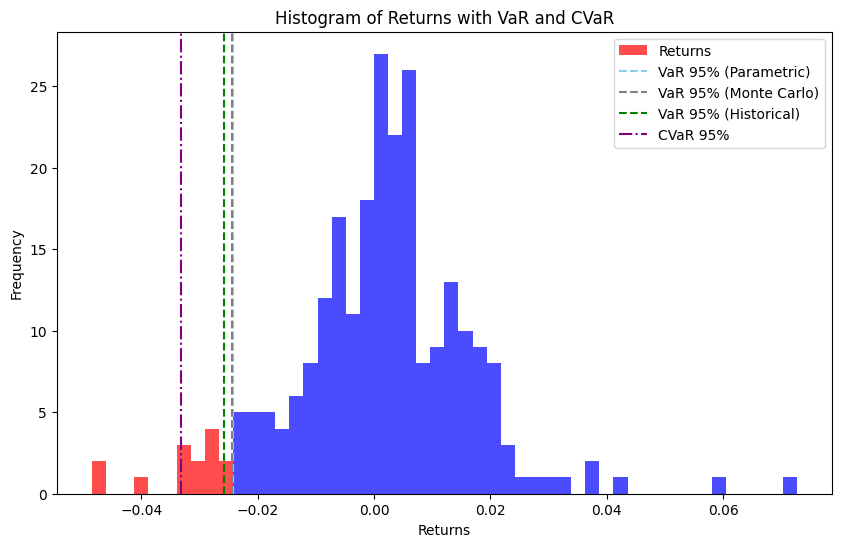

In [35]:
# First, generate the histogram of returns
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_rendimientos['AAPL'], bins=50, color='blue', alpha=0.7, label='Returns')

# Identify bins to the left of hVaR_95 and color them differently
for bin_left, bin_right, patch in zip(bins, bins[1:], patches):
    if bin_left < hVaR_95:
        patch.set_facecolor('red')

# Mark the different VaR and CVaR values on the histogram
plt.axvline(x=VaR_95, color='skyblue', linestyle='--', label='VaR 95% (Parametric)')
plt.axvline(x=MCVaR_95, color='grey', linestyle='--', label='VaR 95% (Monte Carlo)')
plt.axvline(x=hVaR_95, color='green', linestyle='--', label='VaR 95% (Historical)')
plt.axvline(x=CVaR_95, color='purple', linestyle='-.', label='CVaR 95%')

# Add a legend and labels to make the chart more informative
plt.title('Histogram of Returns with VaR and CVaR')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()

# Display the chart
plt.show()

Nuestros resultados:

In [36]:
# Create a DataFrame with various VaR and CVaR calculations
out = pd.DataFrame({'VaR (Normal)': [VaR_95 * 100],
                    'VaR (Historical)': [hVaR_95 * 100],
                    'VaR (Monte Carlo)': [MCVaR_95 * 100],
                    'CVaR': [CVaR_95 * 100]},
                   index=['95% Confidence'])

# Display the DataFrame
out

,VaR (Normal),VaR (Historical),VaR (Monte Carlo),CVaR
95% Confidence,-2.431161,-2.585992,-2.443367,-3.321569


# Introducción al Método Rolling Windows

Recordando lo que se comentó en los códigos anteriores, al trabajar con métricas como VaR o CVar hay que tener muy en claro el periodo específico que representan las muestras con las que las componemos. En este caso, bastaron los últimos 365 precios de cierre para calibrar las métricas válidas para el día de hoy.

La idea del método rolling windows es la siguiente:

Así como usamos los últimos 365 precios de cierre para el cálculo del VaR al día de hoy, si quisiéramos usar la misma metodología para el VaR del día de ayer, basta con recorrernos 1 lugar a la izquierda, es decir, recorrer nuestra ventana de visualización de la muestra un lugar (de ahí el nombre rolling windows). Si quisiéramos el VaR con esta metodología de la semana pasada, basta con recorrer 7 lugares, y así sucesivamente.

Este método es útil para poder comparar métricas de riesgo en ventanas de tiempo distintas, para saber si hubo un incremento en estas o un decremento que pueda ser explicado por outliers, un aumento de volatilidad, o incluso aumento en la media de los retornos, los cuales pueden ser explicados por argumentos macro o micro en el mercado.

Carguemos de nuevo nuestros retornos históricos desde 2008, esta vez sin tomar los últimos 365 datos:

In [45]:
df = yf.download('AAPL', start='2008-01-01')['Close']
returns = df.pct_change().dropna()
returns

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2008-01-03,0.000462
2008-01-04,-0.076335
2008-01-07,-0.013386
2008-01-08,-0.035972
2008-01-09,0.047591
...,...
2025-03-14,0.018171
2025-03-17,0.002389
2025-03-18,-0.006121


Ahora haremos el mismo ejercicio de calcular el VaR paramétrico pero haciendo rolling windows de 365 días.

Para esto usaremos la función rolling() de pandas, donde le indicamos window=365 como argumento para iterar la ventana sobre nuestro dataframe.

In [47]:
# Calculate the rolling mean and standard deviation over a 365-day window.
# These rolling calculations provide an evolving measure of the mean and volatility of returns,
# which are essential for assessing the risk (VaR) dynamically over time.
rolling_mean = returns.rolling(window=365).mean()
rolling_std = returns.rolling(window=365).std()

# Calculate the 95% VaR for each point in time using the rolling mean and standard deviation.
# The 'norm.ppf' function from scipy.stats is used to calculate the inverse of the cumulative
# distribution function of a normal distribution, which gives us the VaR value.
# The first argument (1-0.95) represents the left tail probability (5%),
# and the mean and standard deviation from the rolling calculations are passed as the next arguments.
VaR_95_rolling = norm.ppf(1-0.95, rolling_mean, rolling_std)

# Multiply by 100 to convert to percentages and round to 4 decimal places.
# This step formats the VaR values into a more readable percentage form,
# making it easier to interpret the potential loss.
VaR_95_rolling_percent = (VaR_95_rolling * 100).round(4)

# Optionally, create a DataFrame to visualize the dates and the calculated VaR values.
# This DataFrame associates each date with its corresponding VaR, providing a clear
# historical view of how the assessed risk has changed over time.
vaR_rolling_df = pd.DataFrame({'Date': returns.index, '95% VaR Rolling': VaR_95_rolling_percent.squeeze()})
vaR_rolling_df.set_index('Date', inplace=True)

# Print the last few calculated values as a sample.
# This shows the most recent values of the rolling VaR calculation,
# giving an idea of the current risk assessment based on the latest data.
print(vaR_rolling_df.tail())

            95% VaR Rolling
Date                       
2025-03-14          -2.2906
2025-03-17          -2.2908
2025-03-18          -2.2941
2025-03-19          -2.2896
2025-03-20          -2.2929


Ahora vamos a graficar este VaR paramétrico en el tiempo vs los retornos diarios.

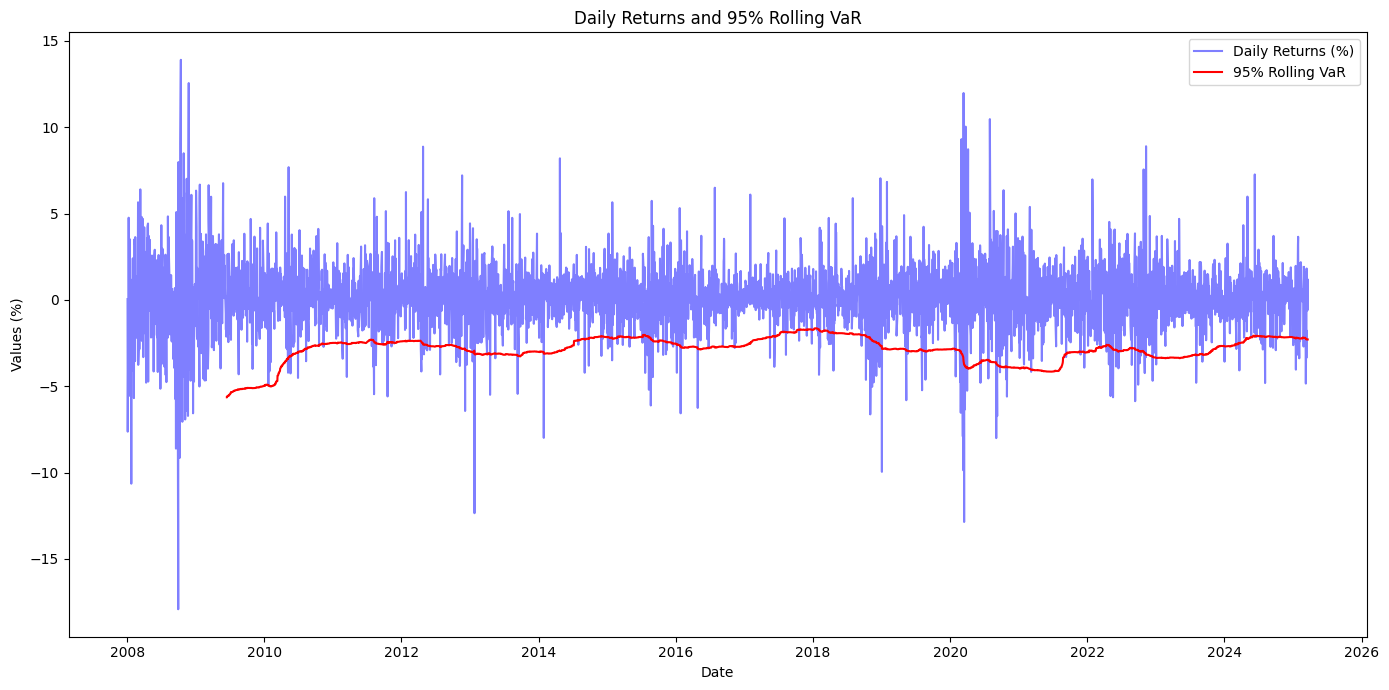

In [48]:
plt.figure(figsize=(14, 7))

# Plot daily returns
# Assuming returns are expressed as fractions, multiply by 100 to convert to percentage
plt.plot(returns.index, returns * 100, label='Daily Returns (%)', color='blue', alpha=0.5)

# Plot the 95% Rolling VaR
plt.plot(vaR_rolling_df.index, vaR_rolling_df['95% VaR Rolling'], label='95% Rolling VaR', color='red')

# Add a title and axis labels
plt.title('Daily Returns and 95% Rolling VaR')
plt.xlabel('Date')
plt.ylabel('Values (%)')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()